In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image


class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
        )
        self.middle = nn.Sequential(
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(48, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

class PairedNoisyDataset(Dataset):
    def __init__(self, root_dir, channel='PMT1'):
        self.channel = channel
        self.samples = []

        for roi_name in os.listdir(root_dir):
            roi_path = os.path.join(root_dir, roi_name)
            if not os.path.isdir(roi_path):
                continue

            timepoint_paths = []
            for timepoint in sorted(os.listdir(roi_path)):
                timepoint_path = os.path.join(roi_path, timepoint)
                if not os.path.isdir(timepoint_path):
                    continue
                pmt_path = os.path.join(timepoint_path, f'{channel}.tiff')
                if os.path.isfile(pmt_path):
                    timepoint_paths.append(pmt_path)

            if len(timepoint_paths) >= 2:
                self.samples.append(timepoint_paths)

        self.resize_transform = transforms.Resize((384, 384))

    def __len__(self):
        return len(self.samples) * 5 

    def __getitem__(self, idx):
        roi_idx = idx % len(self.samples)
        timepoint_paths = self.samples[roi_idx]

        i, j = np.random.choice(len(timepoint_paths), size=2, replace=False)
        img1 = Image.open(timepoint_paths[i]).convert('F')
        img2 = Image.open(timepoint_paths[j]).convert('F')

        img1 = self.resize_transform(img1)
        img2 = self.resize_transform(img2)

        img1 = np.array(img1).astype(np.float32) / 255.0
        img2 = np.array(img2).astype(np.float32) / 255.0

        img1 = torch.from_numpy(img1).unsqueeze(0)
        img2 = torch.from_numpy(img2).unsqueeze(0)

        return img1, img2

def train_model(model, dataloader, device, num_epochs=250):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    def rmse_loss(pred, target):
        return torch.sqrt(torch.mean((pred - target) ** 2))

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = rmse_loss(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], RMSE Loss: {epoch_loss:.6f}")

    print('Training complete.')
    return model

if __name__ == "__main__":
    root_dir = '/Users/alliyaparvez/Documents/canc_img_denois_s25/dataset/n2nin_endoscopic_scans'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # pmt1
    print("Training paired Noise2Noise model for PMT1...")
    dataset_pmt1 = PairedNoisyDataset(root_dir=root_dir, channel='PMT1')
    dataloader_pmt1 = DataLoader(dataset_pmt1, batch_size=4, shuffle=True)

    model_pmt1 = SimpleUNet()
    trained_model_pmt1 = train_model(model_pmt1, dataloader_pmt1, device, num_epochs=250)

    torch.save(trained_model_pmt1.state_dict(), 'noise2noise_paired_model_pmt1.pth')

    #pmt2
    print("\nTraining paired Noise2Noise model for PMT2...")
    dataset_pmt2 = PairedNoisyDataset(root_dir=root_dir, channel='PMT2')
    dataloader_pmt2 = DataLoader(dataset_pmt2, batch_size=4, shuffle=True)

    model_pmt2 = SimpleUNet()
    trained_model_pmt2 = train_model(model_pmt2, dataloader_pmt2, device, num_epochs=250)

    torch.save(trained_model_pmt2.state_dict(), 'noise2noise_paired_model_pmt2.pth')


Training paired Noise2Noise model for PMT1...
Epoch [1/150], RMSE Loss: 0.012242
Epoch [2/150], RMSE Loss: 0.008366
Epoch [3/150], RMSE Loss: 0.005363
Epoch [4/150], RMSE Loss: 0.002054
Epoch [5/150], RMSE Loss: 0.001555
Epoch [6/150], RMSE Loss: 0.001292
Epoch [7/150], RMSE Loss: 0.001196
Epoch [8/150], RMSE Loss: 0.001197
Epoch [9/150], RMSE Loss: 0.001252
Epoch [10/150], RMSE Loss: 0.001200
Epoch [11/150], RMSE Loss: 0.001150
Epoch [12/150], RMSE Loss: 0.001264
Epoch [13/150], RMSE Loss: 0.001219
Epoch [14/150], RMSE Loss: 0.001161
Epoch [15/150], RMSE Loss: 0.001197
Epoch [16/150], RMSE Loss: 0.001189
Epoch [17/150], RMSE Loss: 0.001141
Epoch [18/150], RMSE Loss: 0.001146
Epoch [19/150], RMSE Loss: 0.001116
Epoch [20/150], RMSE Loss: 0.001089
Epoch [21/150], RMSE Loss: 0.001090
Epoch [22/150], RMSE Loss: 0.001096
Epoch [23/150], RMSE Loss: 0.001106
Epoch [24/150], RMSE Loss: 0.001063
Epoch [25/150], RMSE Loss: 0.001120
Epoch [26/150], RMSE Loss: 0.001106
Epoch [27/150], RMSE Loss: 

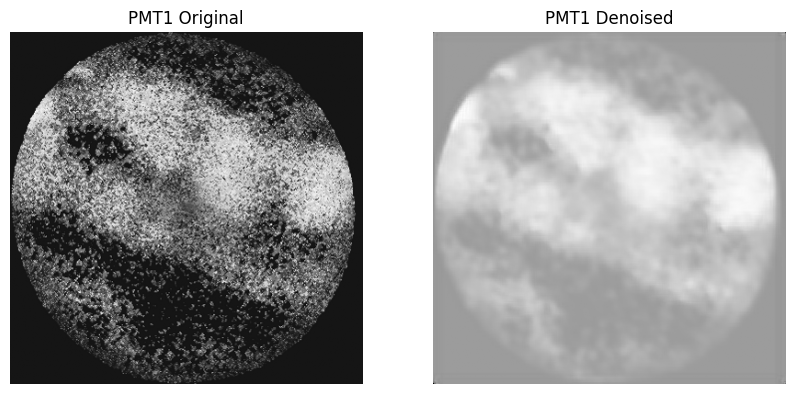

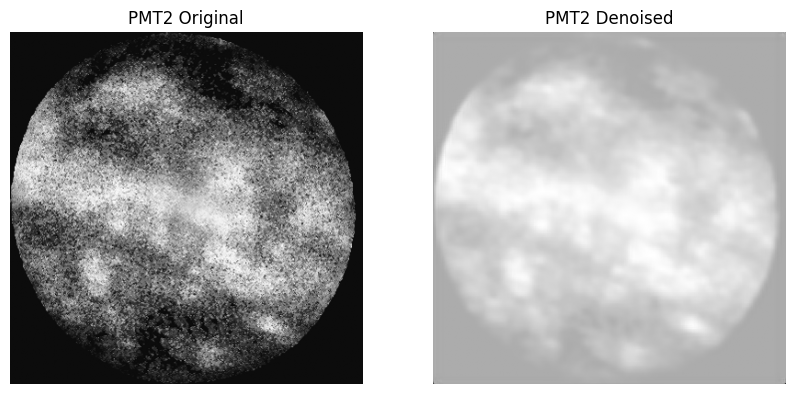

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_pmt1 = SimpleUNet()
model_pmt1.load_state_dict(torch.load('noise2noise_paired_model_pmt1.pth', map_location=device))
model_pmt1 = model_pmt1.to(device)
model_pmt1.eval()

model_pmt2 = SimpleUNet()
model_pmt2.load_state_dict(torch.load('noise2noise_paired_model_pmt2.pth', map_location=device))
model_pmt2 = model_pmt2.to(device)
model_pmt2.eval()


folder_path = '/Users/alliyaparvez/Documents/canc_img_denois_s25/dataset/n2nin_endoscopic_scans/ROI_1/Image-20250326-231205-592'
pmt1_path = f'{folder_path}/PMT1.tiff'
pmt2_path = f'{folder_path}/PMT2.tiff'
def denoise_and_display(image_path, model, title_prefix='PMT'):
    # Load image
    img = Image.open(image_path).convert('F')
    img = img.resize((384, 384))  # Resize to 384x384 if needed
    img_np = np.array(img).astype(np.float32) / 255.0

    # Prepare input
    input_tensor = torch.from_numpy(img_np).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        output_tensor = model(input_tensor)

    # Convert back to numpy
    original = input_tensor.squeeze().cpu().numpy()
    denoised = output_tensor.squeeze().cpu().numpy()

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title(f'{title_prefix} Original')
    axes[0].axis('off')

    axes[1].imshow(denoised, cmap='gray')
    axes[1].set_title(f'{title_prefix} Denoised')
    axes[1].axis('off')

    plt.show()

# =============== Denoise and Display PMT1 and PMT2 Separately ===============
denoise_and_display(pmt1_path, model_pmt1, title_prefix='PMT1')
denoise_and_display(pmt2_path, model_pmt2, title_prefix='PMT2')


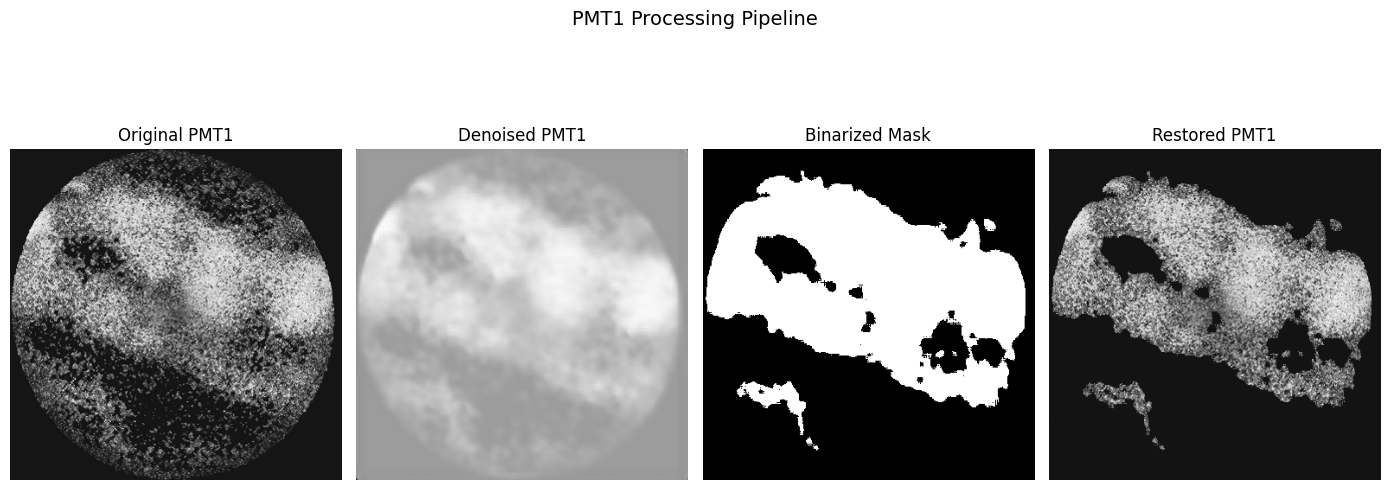

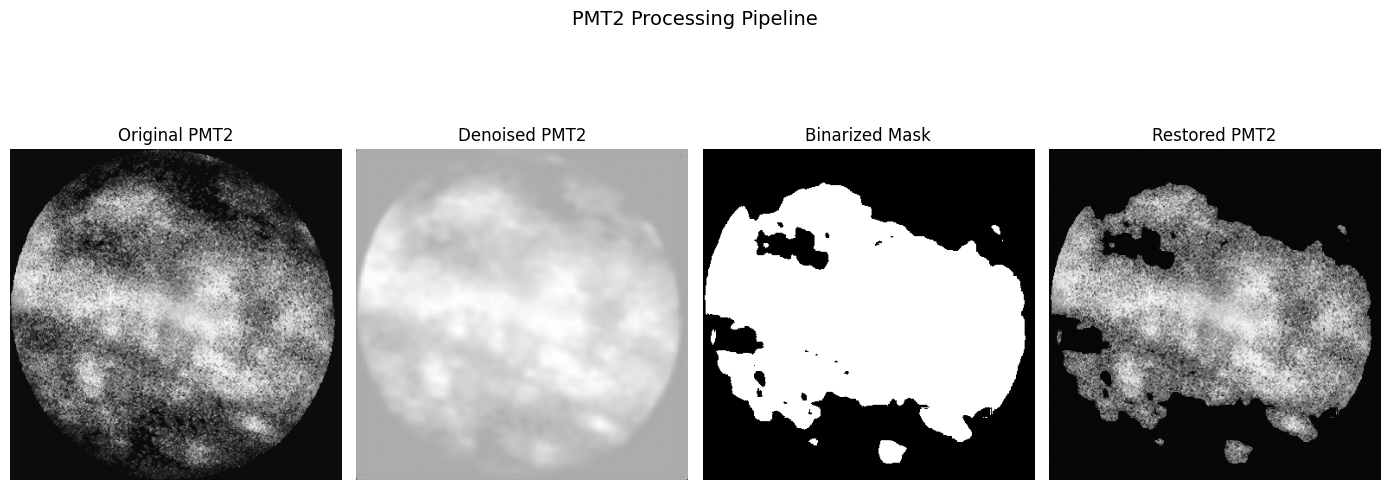

In [5]:
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

# ===== Function to apply model and return original + denoised =====
def denoise(image_path, model):
    img = Image.open(image_path).convert('F').resize((384, 384))
    img_np = np.array(img).astype(np.float32) / 255.0
    input_tensor = torch.from_numpy(img_np).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        output_tensor = model(input_tensor)
    return img_np, output_tensor.squeeze().cpu().numpy()

# ===== Function to binarize and restore signal =====
def binarize_and_restore(original_img, denoised_img):
    thresh = threshold_otsu(denoised_img)
    binary_mask = denoised_img > thresh
    restored_img = original_img * binary_mask
    return binary_mask, restored_img

# ===== Denoise PMT1 and PMT2 =====
original_pmt1, denoised_pmt1 = denoise(pmt1_path, model_pmt1)
original_pmt2, denoised_pmt2 = denoise(pmt2_path, model_pmt2)

# ===== Binarize and Restore =====
mask_pmt1, restored_pmt1 = binarize_and_restore(original_pmt1, denoised_pmt1)
mask_pmt2, restored_pmt2 = binarize_and_restore(original_pmt2, denoised_pmt2)

# ===== Display Results for PMT1 =====
plt.figure(figsize=(14, 6))
plt.suptitle("PMT1 Processing Pipeline", fontsize=14)

plt.subplot(1, 4, 1)
plt.imshow(original_pmt1, cmap='gray')
plt.title("Original PMT1")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(denoised_pmt1, cmap='gray')
plt.title("Denoised PMT1")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(mask_pmt1, cmap='gray')
plt.title("Binarized Mask")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(restored_pmt1, cmap='gray')
plt.title("Restored PMT1")
plt.axis('off')

plt.tight_layout()
plt.show()

# ===== Display Results for PMT2 =====
plt.figure(figsize=(14, 6))
plt.suptitle("PMT2 Processing Pipeline", fontsize=14)

plt.subplot(1, 4, 1)
plt.imshow(original_pmt2, cmap='gray')
plt.title("Original PMT2")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(denoised_pmt2, cmap='gray')
plt.title("Denoised PMT2")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(mask_pmt2, cmap='gray')
plt.title("Binarized Mask")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(restored_pmt2, cmap='gray')
plt.title("Restored PMT2")
plt.axis('off')

plt.tight_layout()
plt.show()
